In [34]:
from matplotlib import pyplot as plt
import sys
import requests
import base64
import json
from pprint import pprint
from dotenv import load_dotenv
import os

sys.path.append('../..')
load_dotenv()
username = os.getenv('SQLPAD_USERNAME')
password = os.getenv('PASSWORD')
print(os.getcwd())
print(username, password)

C:\Users\jepid\PycharmProjects\HydraDX-simulations\hydradx\notebooks\Misc
peter@hydradx.io _cVBjSpB7z7SENJ


In [21]:
# Encode the username and password in Base64
credentials = f"{username}:{password}"
encoded_credentials = base64.b64encode(credentials.encode('utf-8')).decode('utf-8')

headers = {
    'Authorization': f'Basic {encoded_credentials}',
    'Content-Type': 'application/json'  # This is typically required for JSON payloads
}

print()
# print(encoded_credentials)

query = {
    "connectionId": "4a34594e-efa6-4f6e-a594-655ca20f2881",
    "batchText": (
        f"WITH normalized_trades AS ("
        f"  SELECT" 
        f"    timestamp,"
        f"    block,"
        f"    who,"
        f"    operation,"
        f"    (SELECT symbol FROM token_metadata WHERE id = asset_in LIMIT 1) AS asset_in,"
        f"    (SELECT symbol FROM token_metadata WHERE id = asset_out LIMIT 1) AS asset_out,"
        f"    amount_in / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_in LIMIT 1)) AS amount_in,"
        f"    amount_out / POWER(10, (SELECT decimals FROM token_metadata WHERE id = asset_out LIMIT 1)) AS amount_out"
        f"  FROM ("
        f"    SELECT" 
        f"      timestamp,"
        f"      block.height AS block,"
        f"      args->>'who' AS who,"
        f"      name AS operation,"
        f"      (args->>'assetIn')::integer AS asset_in," 
        f"      (args->>'assetOut')::integer AS asset_out,"
        f"      (args->>'amountIn')::numeric AS amount_in," 
        f"      (args->>'amountOut')::numeric AS amount_out"
        f"    FROM event" 
        f"    INNER JOIN block ON block_id = block.id"
        f"    WHERE name LIKE 'Omnipool.%Executed'"
        f"      AND ""timestamp"" BETWEEN '2024-01-01T00:00:00.000Z' AND '2024-01-29T00:00:00.000Z'" 
        f"  ) AS trades"
        f"),"
        f"trades AS ("
        f"  SELECT" 
        f"    timestamp,"
        f"    amount_in / amount_out AS price,"
        f"    amount_in as amount,"
        f"    'buy HDX' as direction"
        f"  FROM normalized_trades"
        f"  WHERE asset_in = 'USDT' AND asset_out = 'HDX'" 
        f"  UNION ALL"
        f"  SELECT" 
        f"    timestamp,"
        f"    amount_out / amount_in AS price,"
        f"    amount_out as amount,"
        f"    'sell HDX' as direction"
        f"  FROM normalized_trades"
        f"  WHERE asset_in = 'HDX' AND asset_out = 'USDT'"
        f")"
        f"SELECT"
        f"  timestamp AS ""time"","
        f"  price,"
        f"  amount,"
        f"  direction "
        f"FROM trades "
        f"ORDER BY 1; "
    )
}

try:
    response = requests.post(
        url='https://sqlpad.play.hydration.cloud/api/batches',
        headers=headers,
        data=json.dumps(query)
    )

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        data = response.json()
        # pprint(data)
        batchID = data['statements'][0]['batchId']
        # print(batchID)
        try:
            statement = requests.get(
                url=f'https://sqlpad.play.hydration.cloud/api/batches/{batchID}/statements',
                headers=headers
            ).json()
            # print("Statement:")
            # pprint(statement)
            statementID = statement[0]['id']
            # pprint(statementID)

            print('waiting for query to finish...')
            if response.status_code == 200:
                data = {'title': 'Not found'}
                while 'title' in data and data['title'] == 'Not found':
                    data = requests.get(
                        url=f'https://sqlpad.play.hydration.cloud/api/statements/{statementID}/results',
                        headers=headers
                    ).json()
                print("Data:")
                # pprint(data)

        except Exception as e:
            print(f"There was a problem with your request: {str(e)}")
    else:
        print(f"Request failed with status code {response.status_code}")

except Exception as e:
    print(f"There was a problem with your request: {str(e)}")


waiting for query to finish...
Data:


Text(0.5, 1.0, 'HDX/USDT price over time')

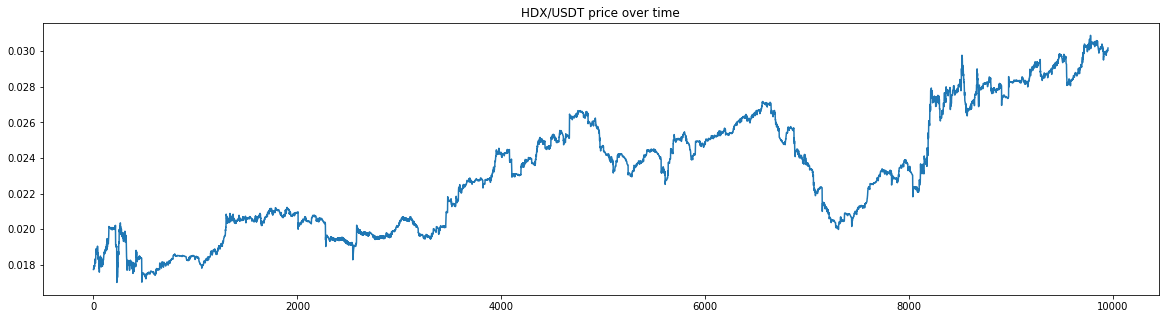

In [22]:
plt.figure(figsize=(20, 5))
plt.plot([line[1] for line in data])
plt.title('HDX/USDT price over time')

Text(0.5, 1.0, 'HDX/USDT buy/sell ratio over the same time period')

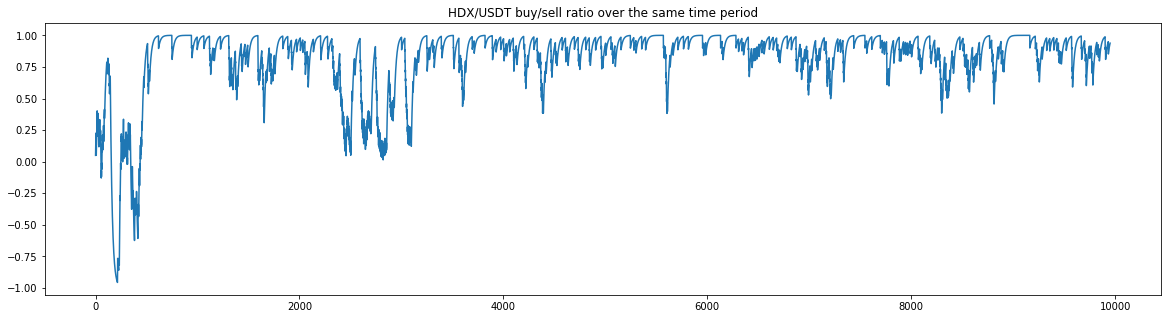

In [23]:
buy_sell_ratio = 0
ratio_trend = []
smooth_factor = 20
for line in data:
    if line[3].startswith('buy'):
        buy_sell_ratio = buy_sell_ratio * (1 - 100 / smooth_factor) + 100 / smooth_factor
    else:
        buy_sell_ratio = buy_sell_ratio * 0.95 - 0.05
    ratio_trend.append(buy_sell_ratio)
plt.figure(figsize=(20, 5))
plt.plot(ratio_trend)
plt.title('HDX/USDT buy/sell ratio over the same time period')

In [9]:
'at'.startswith('a')

True

In [8]:
data

[['2024-01-01T00:58:36.944Z', 0.017734871148197075, 2994.458661, 'buy HDX'],
 ['2024-01-01T01:45:00.649Z', 0.017766539881826974, 100, 'buy HDX'],
 ['2024-01-01T01:47:48.475Z', 0.017790521493355724, 50, 'buy HDX'],
 ['2024-01-01T01:58:36.372Z', 0.017901855989897048, 2994.017105, 'buy HDX'],
 ['2024-01-01T02:05:12.299Z', 0.01791476278961235, 400, 'buy HDX'],
 ['2024-01-01T02:28:06.451Z', 0.01779403320883806, 397.499829, 'sell HDX'],
 ['2024-01-01T02:34:54.838Z', 0.017784949164547335, 330.185198, 'sell HDX'],
 ['2024-01-01T02:51:24.435Z', 0.017772289599999998, 88.861448, 'sell HDX'],
 ['2024-01-01T02:58:24.587Z', 0.01796230428354999, 2993.323736, 'buy HDX'],
 ['2024-01-01T03:19:36.338Z', 0.017936003443708288, 25, 'buy HDX'],
 ['2024-01-01T03:27:18.311Z', 0.017922427928973292, 15, 'buy HDX'],
 ['2024-01-01T03:58:30.271Z', 0.017935238797162138, 2992.488637, 'buy HDX'],
 ['2024-01-01T04:58:24.520Z', 0.017906341000878886, 2991.579867, 'buy HDX'],
 ['2024-01-01T05:57:36.343Z', 0.01794510325328